# Исcледование объявлений о продаже квартир в Санкт-Петербурге

Необходмо определить рыночную стоимость объектов недвижимости и задать параметры, по которым можно построить автоматизированную систему, для отслеживания аномалий и мошеннической деятельности. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Цель исследования** : 
* Определить какие факторы больше всего влияют на стоимость квартиры
* Изучить зависимость стоимости от даты размещения
* Выбрать 10 населённых пунктов с наибольшим числом объявлений. Посчитать среднюю цену квадратного метра в этих населённых пунктах. Выделить среди них населённые пункты с самой высокой и низкой стоимостью жилья. 
* Выяснить, какой район относится к центру города, провести анализ квартир в этой зоне. Также выделите факторы, которые влияют на стоимость квартиры

## Обзор данных

In [56]:
import pandas as pd  # импорт библиотеки pandas
import numpy as np
import re as re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
try:
    df=pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal=',') 
except:
    df=pd.read_csv('real_estate_data.csv', sep='\t', decimal=',')     

In [3]:
warnings.simplefilter('ignore')

In [4]:
df.head(20) # ознакомимся с данными датасета

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,NaN,12.0,14.4,5,NaN,...,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,NaN,26.0,10.6,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.00000000000003
9,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.5,9.0,43.6,7,NaN,...,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Описание данных :
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

добавленные в ходе иследования значения
* usable_area - полезная площадь (отношение жилой площади к общей)
* kitchen_area_2 - отношение площади кухни к общей
* weekday_exposition - день недели публикации
* month_exposition - месяц публикации
* year_exposition - год публикации
* floor_category - категории этажа (первый, последний, другой)

In [5]:
df.info() # получение общей информации о данных в таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   total_images          23699 non-null  int64 
 1   last_price            23699 non-null  object
 2   total_area            23699 non-null  object
 3   first_day_exposition  23699 non-null  object
 4   rooms                 23699 non-null  int64 
 5   ceiling_height        14504 non-null  object
 6   floors_total          23613 non-null  object
 7   living_area           21796 non-null  object
 8   floor                 23699 non-null  int64 
 9   is_apartment          2775 non-null   object
 10  studio                23699 non-null  bool  
 11  open_plan             23699 non-null  bool  
 12  kitchen_area          21421 non-null  object
 13  balcony               12180 non-null  object
 14  locality_name         23650 non-null  object
 15  airports_nearest      18157 non-null

**В датасете присутствуют пропуски** \
    Много пропусков в данных :

* о высоте потолков
* является ли квартира апартаментами
* информация о близости парков и прудов 

Есть пропуски в данных о :
* кол-во этажей в доме
* жилой площадь
* площади кухни
* наличии балкона  

итд

In [6]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Некоторые названия строк необходимо привести к виду хорошего стиля. 'cityCenters_nearest' , 'parks_around3000', 'ponds_around3000'

In [7]:
df.duplicated().sum()

0

### Выводы

1. В таблице представлены разные типы данных. Для удобства работы необходимо привести данные типа 'float'  к 'int'.

2. Благодаря методу info(), мы видим, что в данных есть пропущенные значения, которые могут снизить качество иследования. 

3. Явных повторений строк в данных нет. Но необходимо проверить наличие неявных дубликатов.

## Предобработка данных

### Названия стобцов

Переименовываем столбцы в соответсвии с хорошем стилем.

In [8]:
df = df.rename( columns = {'cityCenters_nearest' : 'city_сenters_nearest', 'parks_around3000' : 'parks_around_3000', 'ponds_around3000' : 'ponds_around_3000' })

In [9]:
df.columns # Еще раз выводим названия столбцов, чтобы убедиться в правильности написания

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_сenters_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

### Дубликаты

В обзоре данных мы убедились в отсутствии явных дубликатов, но теперь проверим неявные. Такие дубликаты могут встречаться в столбцах с качественными значениями (в количествиных данных значения могут совасть, это не будут дубликаты)

In [10]:
df['locality_name']=df['locality_name'].str.lower()
display(df['locality_name'].unique())
len(df['locality_name'].unique())

array(['санкт-петербург', 'посёлок шушары', 'городской посёлок янино-1',
       'посёлок парголово', 'посёлок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина', 'поселок мурино',
       'деревня фёдоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'посёлок металлострой',
       'посёлок городского типа лебяжье',
       'посёлок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'посёлок аннино',
       'поселок городского типа ефимовский', 'посёлок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'посёлок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', '

365

повторы есть, там где слова поселок написаны через е и через ё

In [11]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е') # заменяем на единое написание
len(df['locality_name'].unique())

331

кол-во населенных пунктов уменьшилось на 34. Это почти 10%

### Тип данных

In [12]:
def numeric (df_wrong_type): #приводим все значения к числовому типу
    for wrong_type in df_wrong_type:
        df[wrong_type]= pd.to_numeric(df[wrong_type])


df_wrong_type = (
    ['ceiling_height',
     'living_area',
     'last_price',
     'total_area',
     'floors_total',
     'kitchen_area',
     'balcony',
     'airports_nearest',
     'city_сenters_nearest',
     'parks_around_3000',
     'ponds_around_3000',
    'days_exposition'] 
)
numeric(df_wrong_type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

так же у нас есть данные, которые нужно привести к виду даты.

In [13]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'] , format = '%Y-%m-%dT%H:%M:%S')


### Пропуски

In [14]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_сenters_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Теперь заполним пропуски в значениях по среднему в категории. Посмотрим среднее до заполнения пропусков, чтобы оценить,сильно ли исказятся данные

In [15]:
df['ceiling_height'].mean()

2.7714988968559835

In [16]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Вероятность пропуска в графе высоты потолков не может быть определена на основе другой имеющейся информации, следовательно, эти пропуски были получены случайно. Высота потолка в целом варьируется в диапазоне значений от 2,5 до 3,5 ( ниже 2.5 метров  73 значения - < 1% ; выше 3 метров 305 значений - < 2 %). Перепад в 1 метр существенен. Скорее всего высота потолка будет также влиять на стоимость квартиры. Высота потолка зависит от типа дома. Логично предположить, что в центре Петербурга, где много зданий построенных до начала массового строительства, чаще встречаются высокие потолки или в современных домах высокого класса, которые строятся в более престижных районах. Тогда опираясь на эту логику, можно заполнять пропуски с данными о высоте потолка, медианой, группируя данные по населенным пунктам, так же лучше группировать их еще и по кол-ву этажей. Тогда отделятся дома разных серий, имеющие обычно одинаковую этажность .

In [17]:
df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby('locality_name' and 'floors_total' )['ceiling_height'].transform('median')) # заполняем пропуски

In [18]:
df['ceiling_height'].mean()


2.735932856356704

Часть пропусков все равно осталось, значит для этих строк параметры (название населенного пункта или кол-во этажей)  скорее всего не были указаны. Эти данные можно оставть без замены и не учитывать их в части расчетов.

In [19]:
df['living_area'] = df['living_area'].fillna(df['total_area']-df['kitchen_area'])
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area']-df['living_area'])


Вероятнее всего, пропущенные данные о балконах, значат отсутствие их в квартире. Заменим данные на 0 для удобства.

In [20]:
df['balcony'] = df['balcony'].fillna(0) 
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height             78
floors_total               86
living_area              1464
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             1464
balcony                     0
locality_name              49
airports_nearest         5542
city_сenters_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Отсутствие данных о времени размещении, можно трактовать как факт, что квартира еще продается. Данные об отдаленности аэропортов, прудов, парков и центра города восстановить используя имеющиеся данные не представляется возможным. Качество данных это не улучшит, так же мы не используем эти показатели в данном исследовании. Отсутствие числа этажей может следовать о наличии только одного этажа в здании. Меньше одного этажа быть не может. Заменим данные на единицу. Заменять данные о статусе здания так же нельзя, не исказив их. В этой графе есть как значения 'True' так и 'False'. Возможно Nan-ы так же значат 'False'.

In [21]:
df['floors_total'] = df['floors_total'].fillna(1) 

## Добавление данных для расчета

Расчитаем данные для дальнейшего исследования

In [22]:
df['cost_meter'] = (df['last_price'] / df['total_area']).astype('int') # добавляем данные о стоимости квадратного метра

def floor_category (df) : #делим на категории по количеству этажей
    if df['floor'] == 1:
        return 1
    elif (df['floor'] == df['floors_total']) or(df['floors_total'] == 1) :
        return 3
    else:
        return 2
df['floor_category'] = df.apply(floor_category, axis =1) # создаем колонки с днем, месяцем и годом публикации

df['weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year

df['usable_area'] =  df['living_area'] / df['total_area'] # посчитаем соотношения жилой площади к общей
df['kitchen_area_2'] = df['kitchen_area'] / df['total_area'] # посчитаем соотношения площади кухни к общей

df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around_3000,ponds_nearest,days_exposition,cost_meter,floor_category,weekday_exposition,month_exposition,year_exposition,usable_area,kitchen_area_2
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,NaN,...,2.0,755.0,NaN,120370,2,3,3,2019,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,2.75,11.0,18.60,1,NaN,...,0.0,NaN,81.0,82920,1,1,12,2018,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,2.55,5.0,34.30,4,NaN,...,2.0,574.0,558.0,92785,2,3,8,2015,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,2.60,14.0,NaN,9,NaN,...,3.0,234.0,424.0,408176,2,4,7,2015,NaN,NaN
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,NaN,...,1.0,48.0,121.0,100000,2,1,6,2018,0.320000,0.410000
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.40,5,NaN,...,NaN,NaN,55.0,95065,2,0,9,2018,0.473684,0.299342
6,6,3700000.0,37.30,2017-11-02,1,2.66,26.0,10.60,6,NaN,...,0.0,NaN,155.0,99195,2,3,11,2017,0.284182,0.386059
7,5,7915000.0,71.60,2019-04-18,2,2.75,24.0,52.70,22,NaN,...,0.0,NaN,NaN,110544,2,3,4,2019,0.736034,0.263966
8,20,2900000.0,33.16,2018-05-23,1,2.70,27.0,15.43,26,NaN,...,NaN,NaN,189.0,87454,2,2,5,2018,0.465320,0.265682
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,NaN,...,0.0,NaN,289.0,88524,2,6,2,2017,0.714754,0.106557


## Исследование площади, цены, числа комнат, высоты потолков

диапозон ставился после построения графика и отсечения значений за 200 кв. метров из-за малого кол-ва значений. Большинство значений от 40 до 70 кв.м

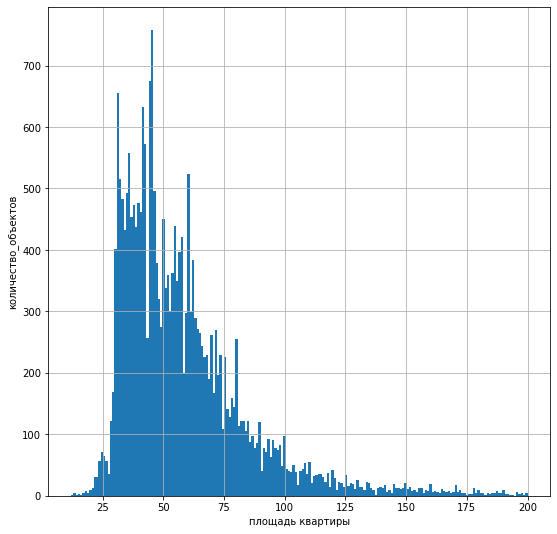

In [86]:
df['total_area'].hist( bins = 200 , range = (12 , 200),  figsize=(9,9)) #строим график разброса площадей квартир
plt.xlabel('площадь квартиры')
plt.ylabel('количество_объектов')
plt.show()

In [79]:
df['total_area'].quantile( .25)

40.0

In [ ]:
df['total_area'].quantile( .25)

69.9

По полученной гистограмме видим, что площади большой части квартир распределены в границах 30 - 75 метров, с пиками на примерно 42 метрах квадратных и 60

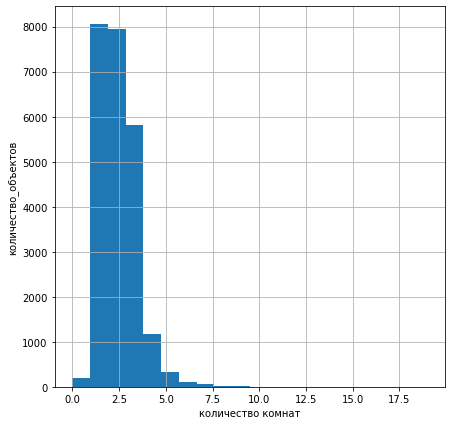

In [85]:
df['rooms'].hist( bins = 20,  figsize=(7,7)) #строим график кол-ва комнат
plt.xlabel('количество комнат')
plt.ylabel('количество_объектов')
plt.show()

Больше всего однушек, потом двушек. Совсем мало с количеством больше 5 комнат.

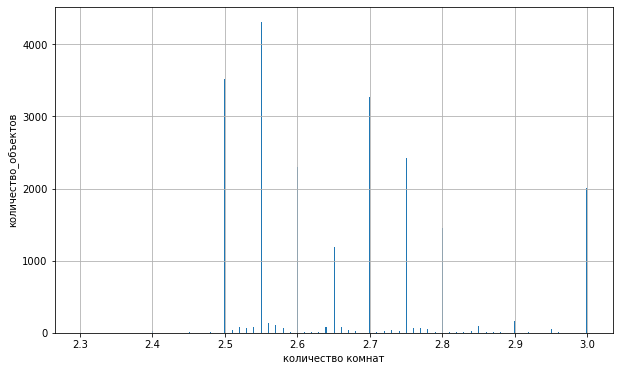

In [84]:
df['ceiling_height'].hist( bins = 500, range = (2.3, 3), figsize=(10,6)) #строим график высоты потолков
plt.xlabel('количество комнат')
plt.ylabel('количество_объектов')
plt.show()

In [ ]:
Q1 = df['ceiling_height'].quantile( .25)
Q1

2.55

In [ ]:
Q3 = df['ceiling_height'].quantile( .75)
Q3

2.75

Видим пики, которые приходятся на конкретные  значения от 2.5  до 3 метров. \
Большая часть значений попадает интерквартильный размах от 2.55 до 2.75. Есть аномально большие значения, отсекаю значения больше 4 метров. \
Большая часть квартир относится к типовым  зданиям.

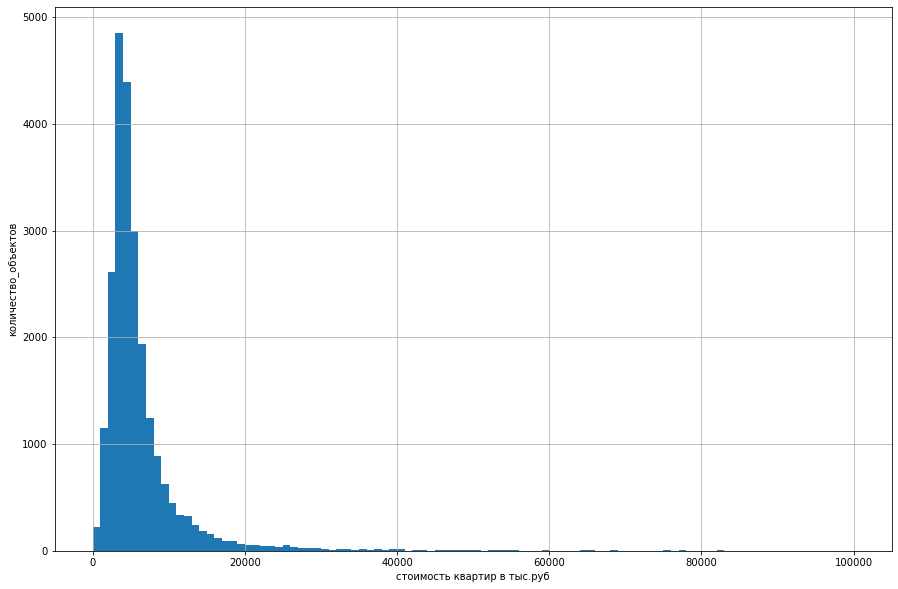

In [87]:
df['coast'] = df ['last_price'] / 1000 # приводим запись стоимости квартир в тыс.руб
df['coast'].hist( bins = 100, range = (0,100000), figsize=(15,10))
plt.xlabel('стоимость квартир в тыс.руб')
plt.ylabel('количество_объектов')
plt.show()

Большая часть квартир находится в пределах 20 миллионов рублей

###  Редкие и выбивающиеся значения

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.000000,6.000000e+00,9.000000e+00,1.400000e+01,5.000000e+01
last_price,23699.0,6.541549e+06,1.088701e+07,12190.000000,3.400000e+06,4.650000e+06,6.800000e+06,7.630000e+08
total_area,23699.0,6.034865e+01,3.565408e+01,12.000000,4.000000e+01,5.200000e+01,6.990000e+01,9.000000e+02
rooms,23699.0,2.070636e+00,1.078405e+00,0.000000,1.000000e+00,2.000000e+00,3.000000e+00,1.900000e+01
ceiling_height,23621.0,2.735933e+00,9.959030e-01,1.000000,2.550000e+00,2.650000e+00,2.750000e+00,1.000000e+02
floors_total,23699.0,1.063872e+01,6.610834e+00,1.000000,5.000000e+00,9.000000e+00,1.600000e+01,6.000000e+01
living_area,22235.0,3.490959e+01,2.311770e+01,2.000000,1.880000e+01,3.004000e+01,4.280000e+01,5.710000e+02
floor,23699.0,5.892358e+00,4.885249e+00,1.000000,2.000000e+00,4.000000e+00,8.000000e+00,3.300000e+01
kitchen_area,22235.0,1.086496e+01,6.804054e+00,0.000000,7.000000e+00,9.300000e+00,1.200000e+01,2.300000e+02
balcony,23699.0,5.910798e-01,9.592982e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00


#### Вывод
Дополняя ранее выведенные графики полученной информацией, можно сказать, что :
1) Площадь квартир варьируется в пределах 40 - 70 кв. метров. Выбросами предлагаю считать значения ниже 30 или выше 120, чтобы более полно представить рынок, а не только самые распространенные квартиры

2) Кол-во комнат  от 1 до 3. Больше 6 встречается редко. Возможна выборка до 4, опираясь на график

3) Цена продажи с учетом стандартного отклонения - 3,4 млн 6,8 млн. Учитывая гистограмму предлагаю учитывать до 10 млн

4) Высота потолков от 2,55 до 2,75 млн, возможно округлить до 3 м, так как в центре Петербурга таких квартир не мало и этот показатель влияет на стоимость квартиры.

In [29]:
average_values=df[(df['total_area']>30) & (df['total_area']<120) & (df['rooms'] < 4 ) & (df['last_price']>3400000) & (df['last_price']<10000000) & (df['ceiling_height']>2.55) & (df['ceiling_height']<=3) ]

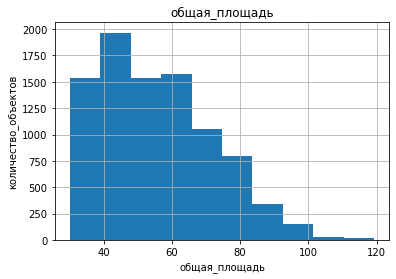

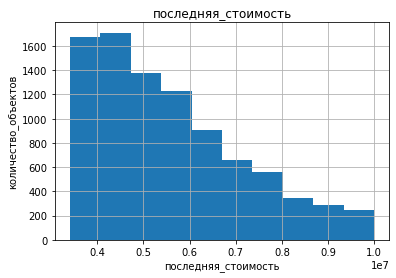

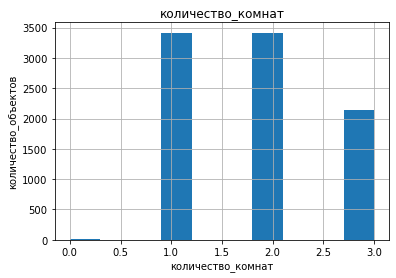

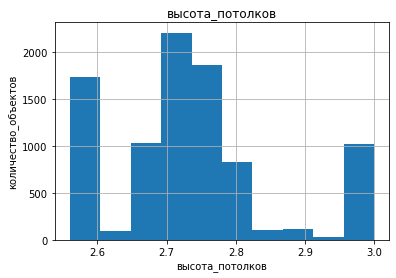

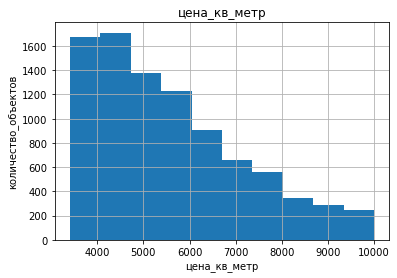

In [30]:
columns = ['total_area', 'last_price', 'rooms', 'ceiling_height', 'coast']
name_columns = ['общая_площадь', 'последняя_стоимость', 'количество_комнат', 'высота_потолков', 'цена_кв_метр']
count = ['м кв.', 'млн.руб', 'число', 'м', 'м']
for i in range(len(columns)):
    average_values[columns[i]].hist()
    plt.title( name_columns[i])
    plt.xlabel(name_columns[i])
    plt.ylabel('количество_объектов')
    plt.show()
    

Теперь в переменной average_vaslues хранятся данные без редких значений и выбросов. По ним мы можем судить о том, что цена за кв.метр в среднем равна 45000 руб, самая популярная высота потолков - 2.7 метра, однушек и двушек примерно равное кол-во, больше всего квартир площадью 50 кв.метров, а стоимость в среднем - 4.5 млн руб

### Изучаем  время продажи квартиры.

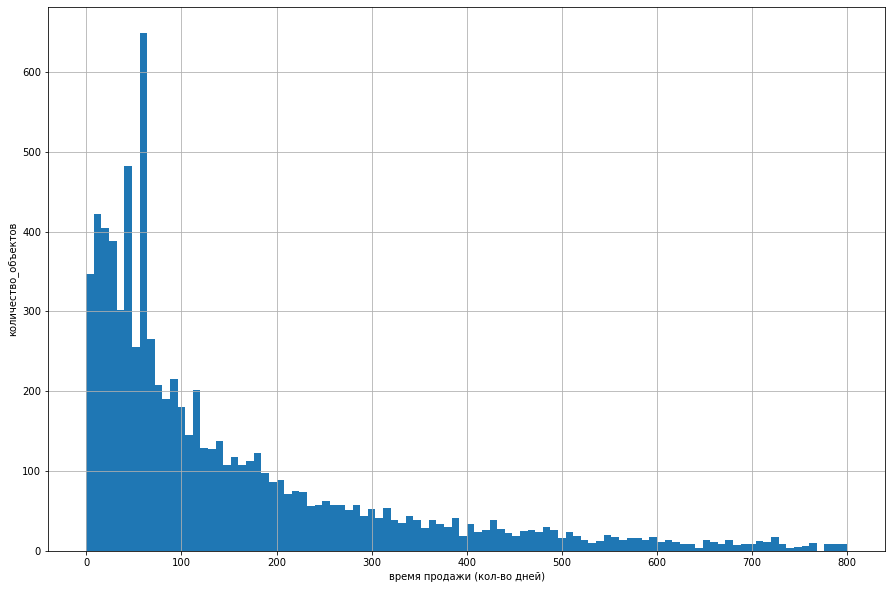

In [89]:
average_values['days_exposition'].hist( bins = 100, range = (0,800), figsize=(15,10)) #строим гистограму. Максимальное значение 1580
#большая часть значений находится в пределах 800
plt.xlabel('время продажи (кол-во дней)')
plt.ylabel('количество_объектов')
plt.show()

На гистограмме показано время продажи квартир. Заметны четыре явных пика, выбивающиеся среди других значений. После приближения стало понятно, что пики значений равноудалены друг от друга. Возможно на сайте есть срок размещения, после которого человек должен обновить объявление или оно автоматически закрывается, тогда обновлять объявление нужно через одинаковый срок.

In [92]:
print(average_values['days_exposition'].mean())
average_values['days_exposition'].median()

173.63269639065817


91.0

Среднее и медиана разнится в 2 раза. Среднее сильно подвержено выбросам

In [33]:
df_exposition = average_values['days_exposition']
df_exposition.describe()

count    8007.000000
mean      173.632696
std       212.483798
min         2.000000
25%        43.000000
50%        91.000000
75%       219.000000
max      1485.000000
Name: days_exposition, dtype: float64

#### Вывод
Таким образом, нормальным сроком продажи квартиры считается от 45 до 232 дней. Все что больше или меньше - очень быстро или подозрительно долго.

### Влияние различных факторов на стоимость квдратного метра 

<AxesSubplot:>

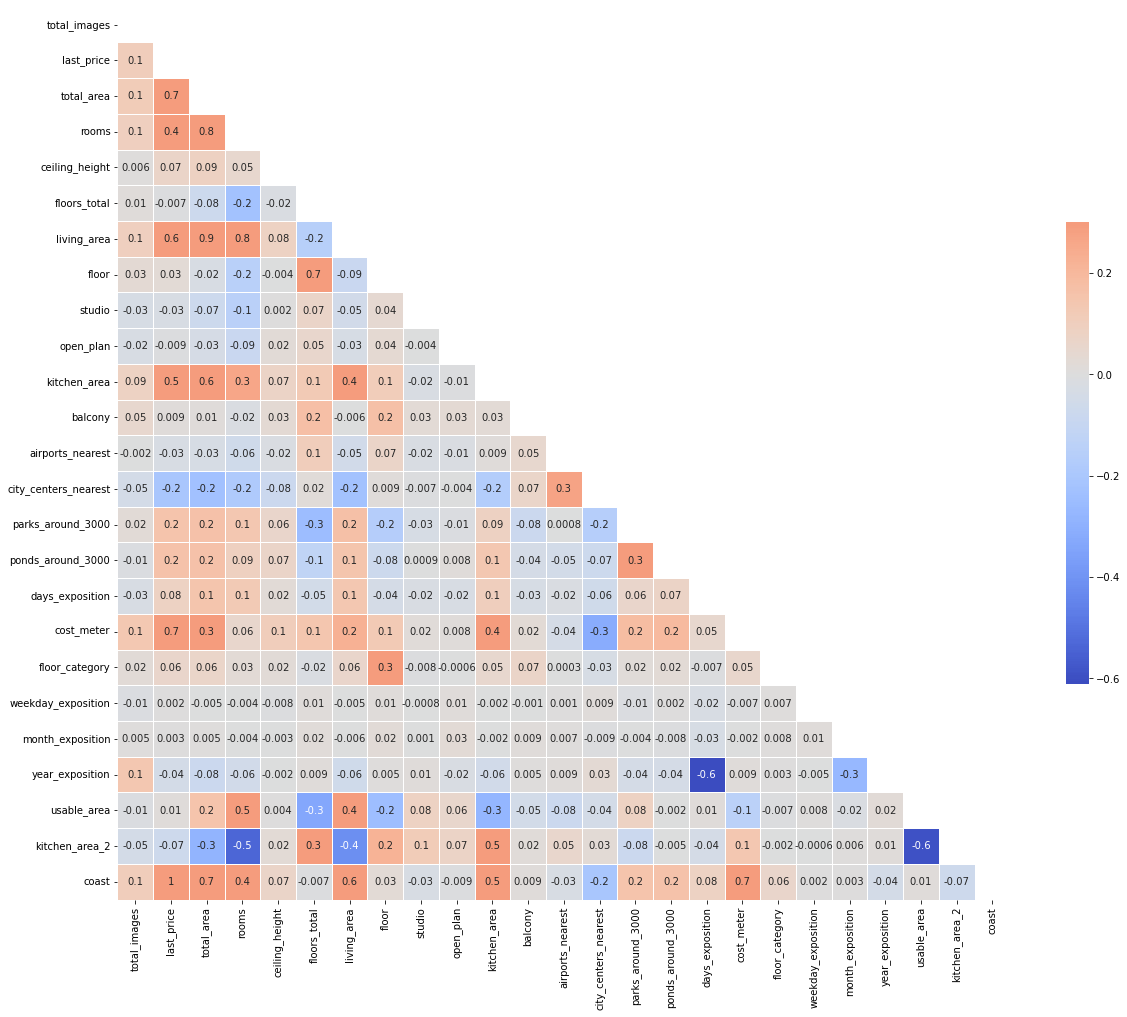

In [107]:
corr =df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 17))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, annot = True,fmt='.1g', cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Рассмотрим подробнее влияния каждого фактора на стоимость 

Сначала изучим влияние общей площади на стоимость квартиры. 

<AxesSubplot:xlabel='total_area'>

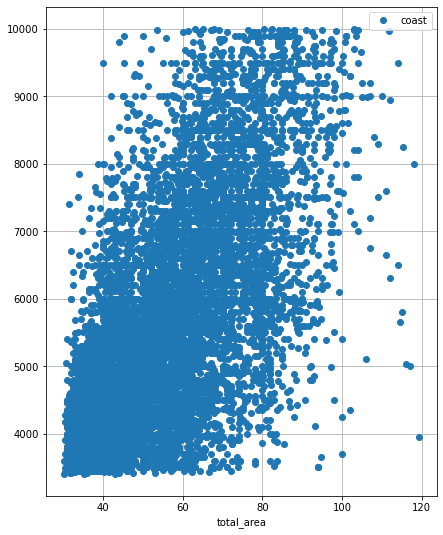

In [34]:
average_values.sort_values('total_area').plot(x='total_area', y='coast', style='o', grid=True, figsize=(7,9))

In [35]:
average_values['coast'].corr(average_values['total_area'])

0.6403205834521319

Уровень корелляции достаточно высокий. Большинство квартир имеют площадь до 70 метров и эти значения концентрируются в районе стоимости за квадратный метр 40000 -60000. С увеличением площади значения стоимости становятся выше, что подтверждает наличие связи между этими показателями

<AxesSubplot:xlabel='coast', ylabel='rooms'>

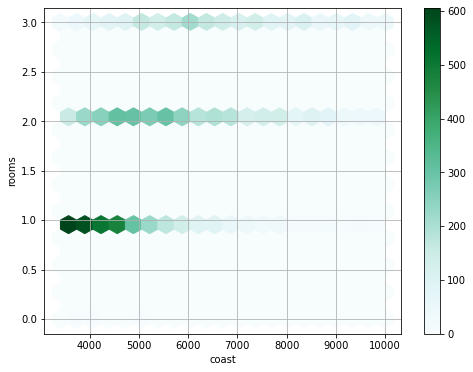

In [36]:
average_values.plot(x='coast', y='rooms', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 

In [37]:
average_values['coast'].corr(average_values['rooms'])


0.4617753447199706

Квартир с одной комнатой больше, чем других. Стоимость увеличивается с добавлением комнат.

<AxesSubplot:xlabel='coast', ylabel='city_сenters_nearest'>

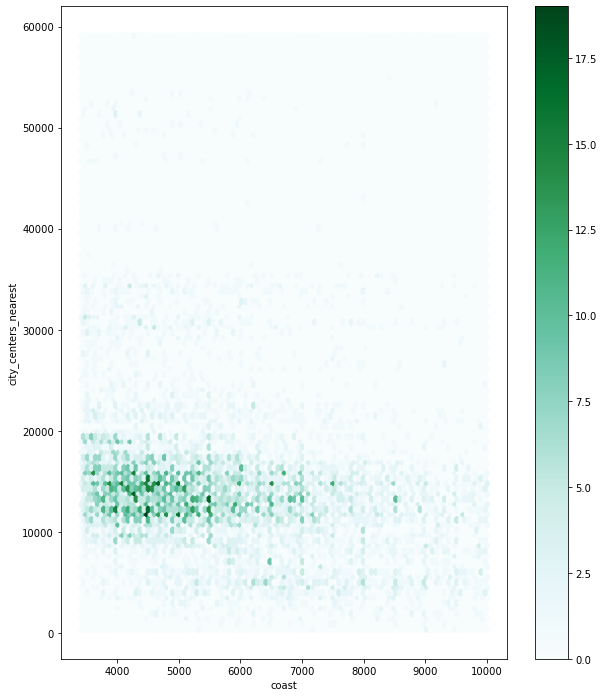

In [38]:
average_values.plot(x='coast', y='city_сenters_nearest', kind='hexbin', figsize = (10,12), sharex=False,) 

In [39]:
average_values['coast'].corr(average_values['city_сenters_nearest'])


-0.22963306606346073

По графику видно, что на расстоянии от центра  20 км квартиры со стоимостью выше 70000 не почти не встречаются. Хотя уровень корелляции слабый. Получается на стоимость больше влияет площади и кол-во квартир.

<AxesSubplot:xlabel='floor_category'>

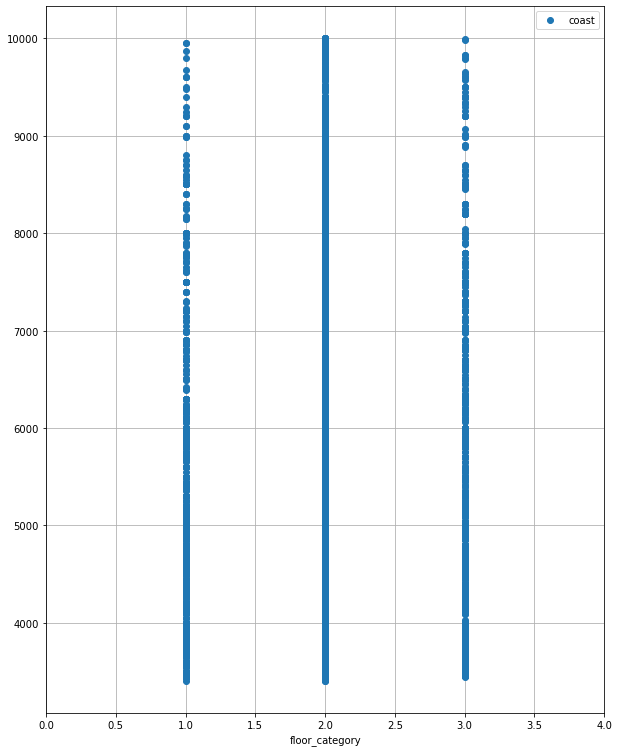

In [40]:
average_values.sort_values('floor_category').plot(x='floor_category', y='coast', xlim=(0,4), style='o', grid=True, figsize=(10,13)) 

In [41]:
average_values['coast'].corr(average_values['floor_category'])


0.029878355255780125

Уровень корреляции почти равен нулю, но заметно что квартиры на первом и последнем этаже реже встречаются квартиры дороже 80000, когда так квартир на других этажах так же много.

### Влияние дня, месяца и года  публикации на стоимость квадратного метра и срока продажи 

In [42]:
average_values['coast'].corr(average_values['weekday_exposition'])

-0.0016284558110355053

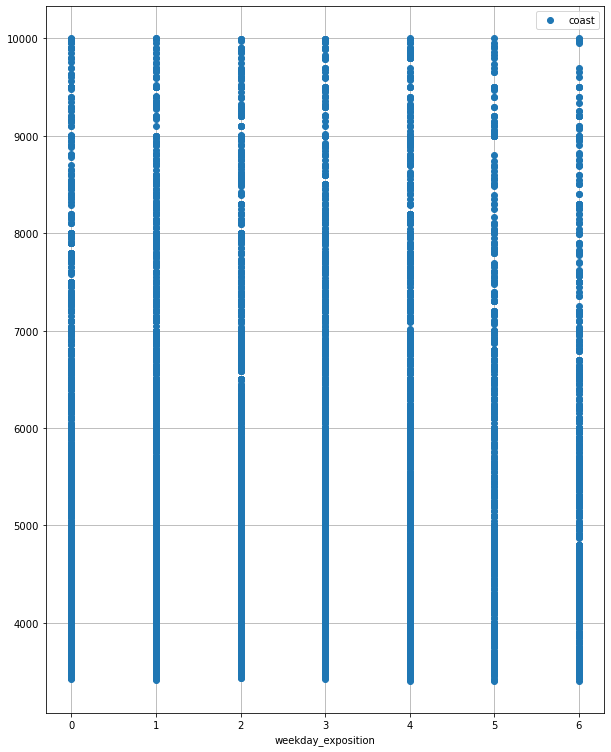

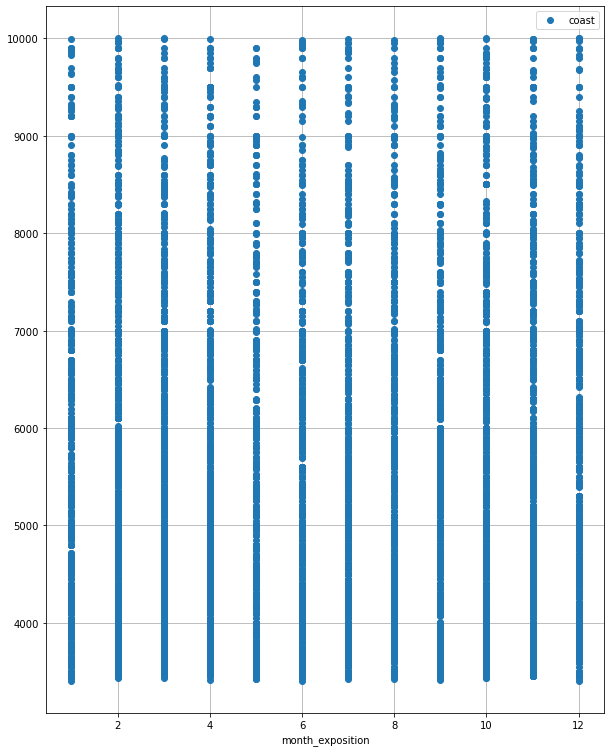

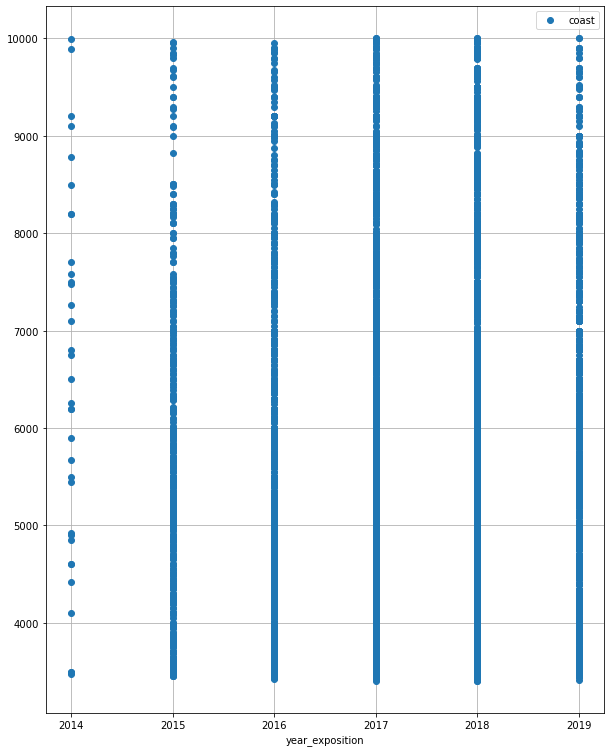

In [43]:
columns = ['weekday_exposition', 'month_exposition', 'year_exposition']
for i in columns :
    average_values.sort_values(i).plot(x=i, y='coast', style='o', grid=True, figsize=(10,13))  

Больше всего объявлений опубликовано во вторник и четверг, день недели на стоимость квартир не влияет. Если говорить о месяцах, заметно, что стоимость на квартиры меньше в мае, чем в других. Больше всего объявлений датируются 2018 годом. Квартиры в 2014, 2015 году и 2019 дешевле, чем в 2016-2018

In [44]:
average_values.pivot_table(values = 'coast',
               index = 'locality_name',
               aggfunc =['count','mean','max','min'],
               margins =True).sort_values(('count', 'coast'), ascending = False).head(11).round({('mean','coast'):2})


,count,mean,max,min
,coast,coast,coast,coast
locality_name,,,,
All,8978,5597.40,9999.999,3405.0
санкт-петербург,6854,5837.77,9999.999,3415.0
поселок парголово,253,4800.00,9140.000,3450.0
поселок мурино,244,4578.21,8500.000,3405.0
поселок шушары,203,4662.79,8179.000,3430.0
деревня кудрово,184,4868.60,9950.000,3435.0
всеволожск,152,4644.01,8999.999,3420.0
пушкин,144,5871.15,9973.000,3470.0


В этом графике представлены населенные пункты с наибольшим числом объявлений. В третьем столбце указана средняя стоимость жилья. Самая большая средняя стоимость в Сестрорецке, а самая маленькая в Колпино.

<AxesSubplot:xlabel='km_to_the_center'>

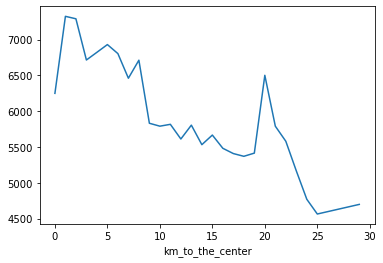

In [45]:
df_peter = average_values.query( " locality_name == 'санкт-петербург'" )
df_peter['km_to_the_center'] = df_peter['city_сenters_nearest']/1000
df_peter['km_to_the_center']= df_peter['km_to_the_center'].round()
df_peter=df_peter.query('km_to_the_center != 26') # убрали два значения , сильно выбивающиеся из графика
df_peter=df_peter.query('km_to_the_center != 28')
df_peter.groupby('km_to_the_center')['coast'].mean().plot(x='coast', y='km_to_the_center')

По графику видно, что стоимость резко падает после 20 км. На этом значении идет граница центра города

### Изучение значений для квартир в центре Санкт-Петербурга

In [46]:
df_peter_centre = df_peter[df_peter['km_to_the_center'] <20]

<AxesSubplot:>

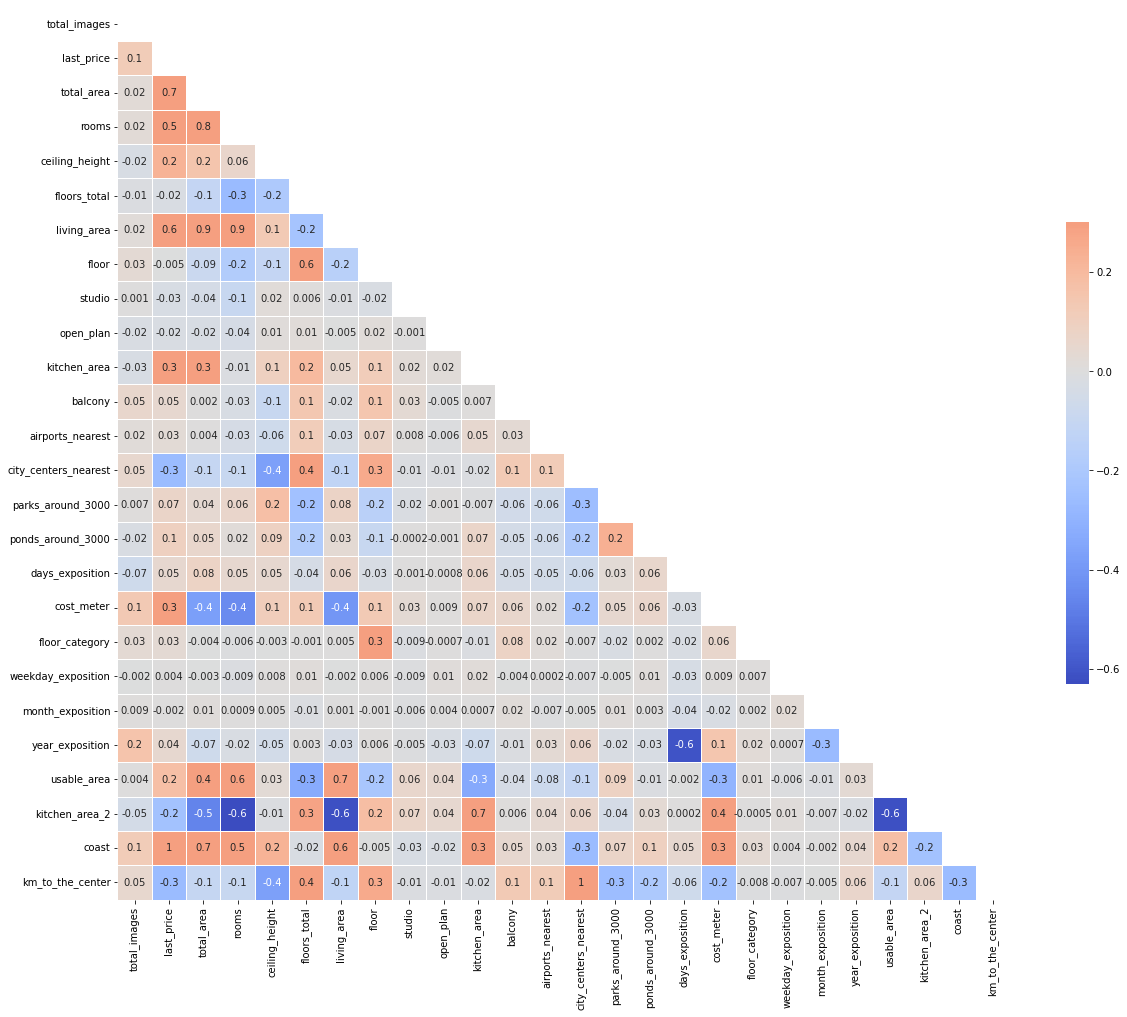

In [108]:
corr =df_peter_centre.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 17))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, annot = True,fmt='.1g', cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

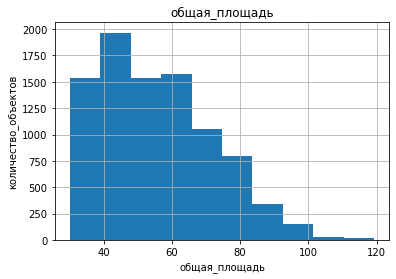

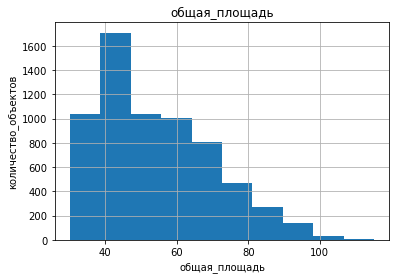

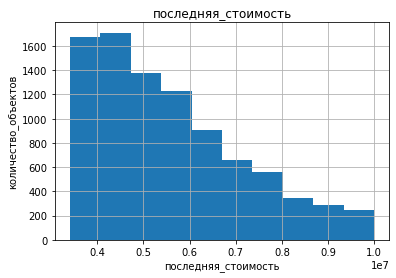

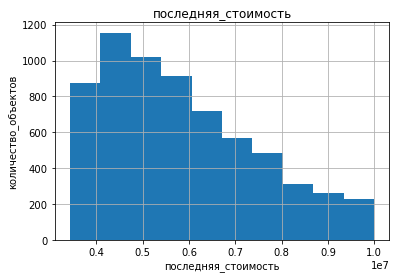

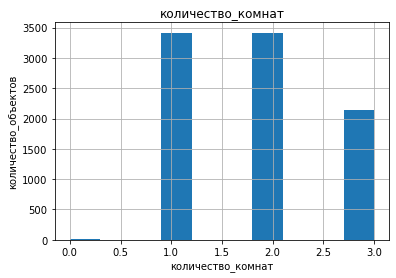

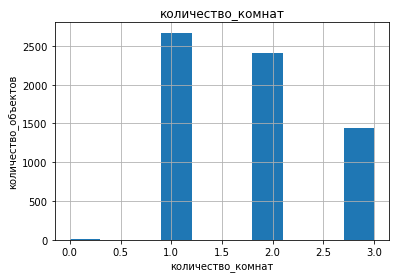

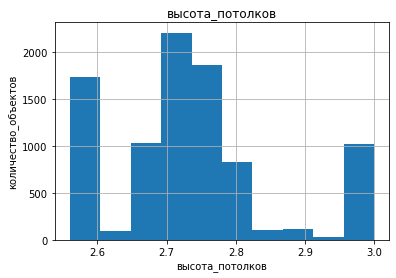

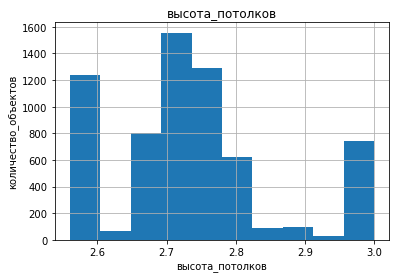

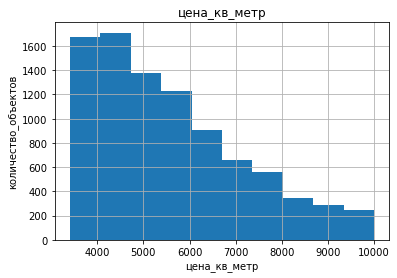

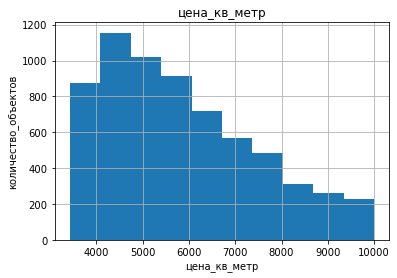

In [47]:
columns = ['total_area', 'last_price', 'rooms', 'ceiling_height', 'coast']
name_columns = ['общая_площадь', 'последняя_стоимость', 'количество_комнат', 'высота_потолков', 'цена_кв_метр']
count = ['м кв.', 'млн.руб', 'число', 'м', 'м']
for i in range(len(columns)):
    average_values[columns[i]].hist()
    plt.title( name_columns[i])
    plt.xlabel(name_columns[i])
    plt.ylabel('количество_объектов')
    plt.show()
    df_peter_centre[columns[i]].hist()
    plt.title( name_columns[i])
    plt.xlabel(name_columns[i])
    plt.ylabel('количество_объектов')
    plt.show()

По полученным данным, средняя стоимость квартир в центре - от 40000 до 50000 руб, больше всего представлено однокомнатных квартир, высота потолков 2.7 метров - встречается чаще всего.  \
Больше всего продаются квартиры стоимостью от 4.5 млн руб до 5 млн. руб, а общая площадь от 40 до 50 метров. \
Если сравнивать с остальными предложениями, квартиры в центре в среднем дороже на 10тыс за кв. метр \
Однакомнатные и двухкомнатные  встречаются чаще. Конечная стоимость выше на полмиллиона. \
Квартиры больше 40 кв метров встречаются значительно реже. 

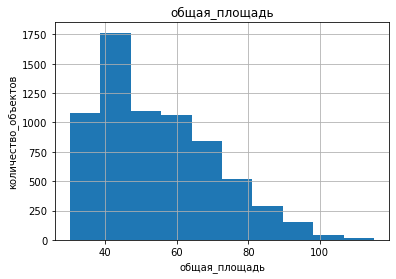

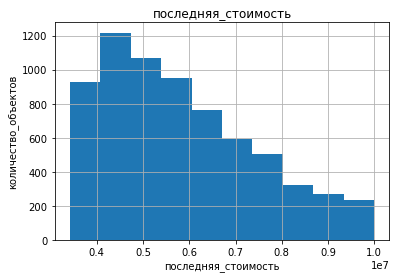

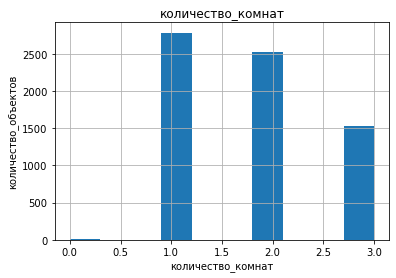

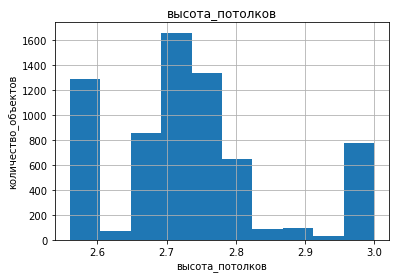

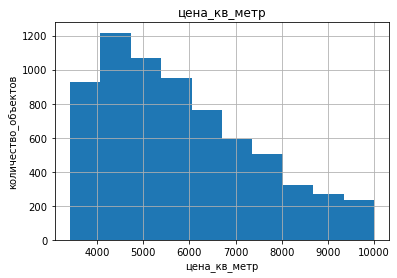

In [48]:
columns = ['total_area', 'last_price', 'rooms', 'ceiling_height', 'coast']
name_columns = ['общая_площадь', 'последняя_стоимость', 'количество_комнат', 'высота_потолков', 'цена_кв_метр']
count = ['м кв.', 'млн.руб', 'число', 'м', 'м']
for i in range(len(columns)):
    df_peter[columns[i]].hist()
    plt.title( name_columns[i])
    plt.xlabel(name_columns[i])
    plt.ylabel('количество_объектов')
    plt.show()

<AxesSubplot:xlabel='floor_category'>

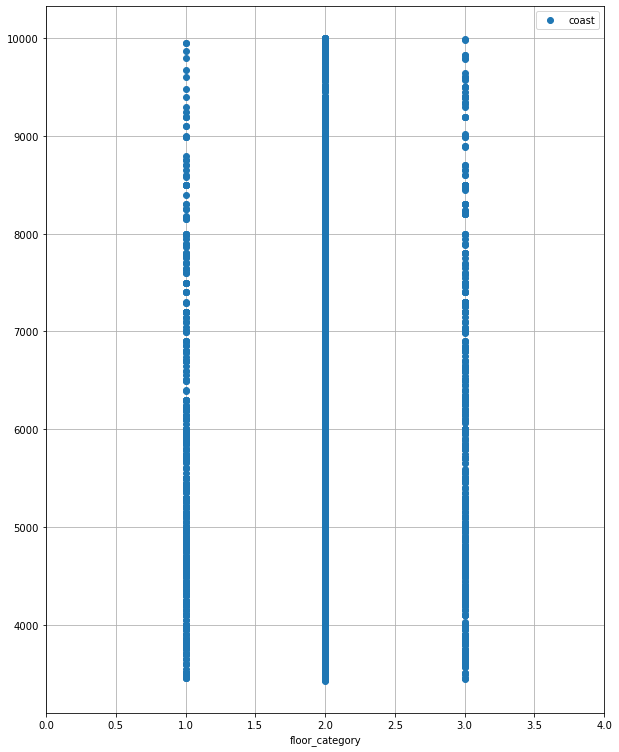

In [49]:
df_peter_centre.sort_values('floor_category').plot(x='floor_category', y='coast', xlim=(0,4), style='o', grid=True,  figsize=(10,13)) 
 

Среди первых и последних этажей стоимость ниже. Среди квартир на первых этажах стоимость ниже, чем на последних.

<AxesSubplot:xlabel='weekday_exposition'>

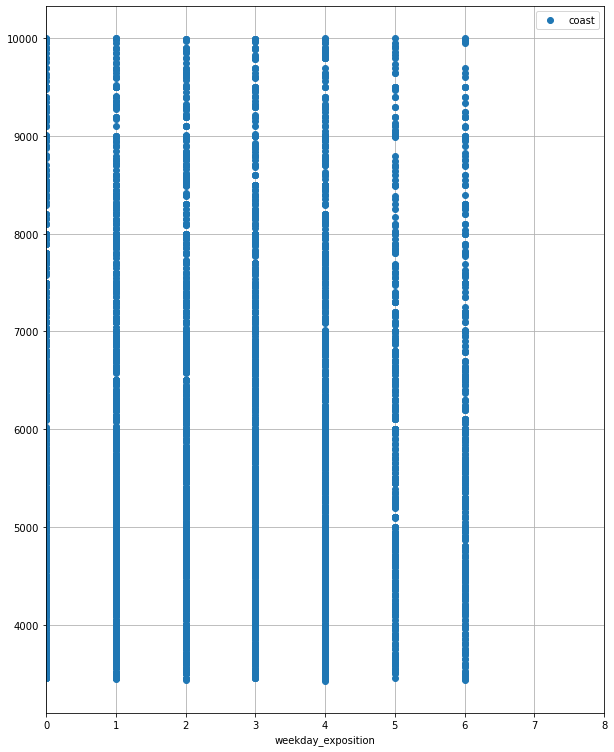

In [50]:
df_peter_centre.sort_values('weekday_exposition').plot(x='weekday_exposition', y='coast', xlim=(0,8), style='o', grid=True, figsize=(10,13)) 

Стоимость квартир, выставленных в субботу и воскресенье немного ниже, чем в рабочие дни

<AxesSubplot:xlabel='month_exposition'>

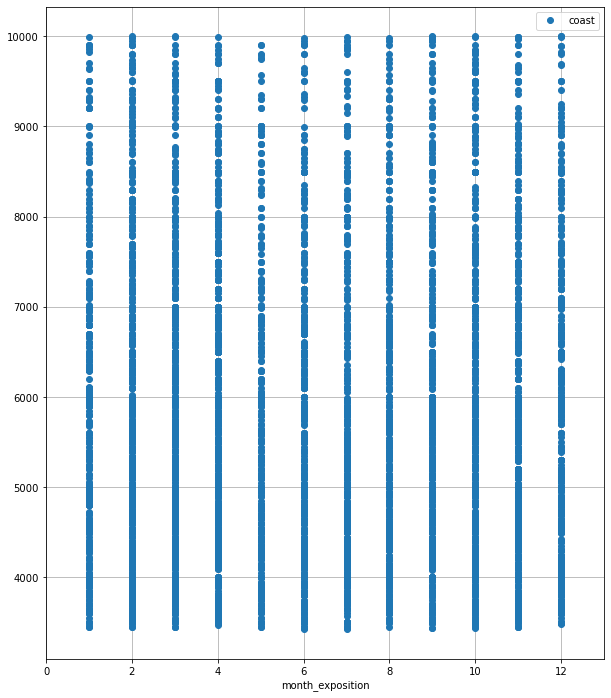

In [51]:
df_peter_centre.sort_values('month_exposition').plot(x='month_exposition', y='coast', xlim=(0,13), style='o', grid=True, figsize=(10,12))

В феврале, марте и с августа по октябрь график плотнее, больше квартир продаются по высокой цене от 8 млн руб, но разница по графикам малозаметна

<AxesSubplot:xlabel='year_exposition'>

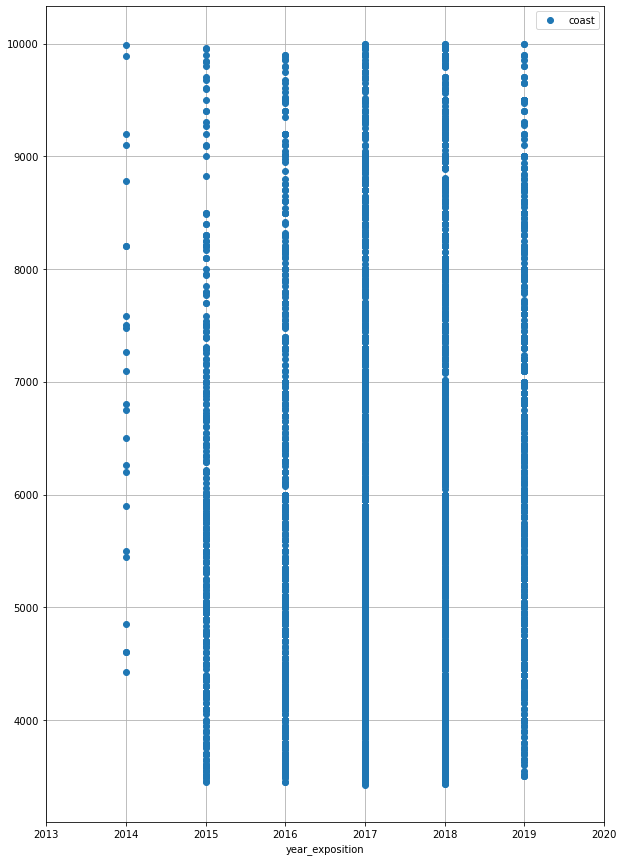

In [52]:
df_peter_centre.sort_values('year_exposition').plot(x='year_exposition', y='coast', xlim=(2013,2020), style='o', grid=True, figsize=(10,15))

Больше всего дорогих квартир продавалось в 2017-2018 году, в 2014 объявлений крайне мало, видимо это сязано с тем, что сервис тогда только появился

## Вывод

В ходе исследования была определена основная выборка и ее размах. Площадь квартир варьируется в пределах 40 - 70 кв. метров. Кол-во комнат от 1 до 3. Больше 6 встречается редко. Цена продажи с учетом стандартного отклонения - 3,4 млн 6,8 млн. Высота потолков от 2,55 до 2,75 млн, возможно округлить до 3 м 

Выбросами было решено считать значения общей площади ниже 30 и выше 120, с количеством комнат до 4, стоимостью до 10 млн и от 3.4 млн, а высотой потолков от 2.55 до 3 

Большинство квартир имеют площадь до 60 метров и эти значения концентрируются в районе стоимости за квадратный метр 40000 -60000. С увеличением площади значения стоимости становятся выше, что подтверждает наличие связи между этими показателями. На стоимость ощутимо влияет площадь и кол-во комнат. 

Нормальным сроком продажи квартиры считается от 45 до 232 дней. Все что больше или меньше - очень быстро или подозрительно долго. 

Самое большое число объявлений в следующих населенных пунктах: 
* санкт-петербург 
* поселок парголово 
* поселок мурино 
* поселок шушары 
* деревня кудрово 
* всеволожск 
* пушкин 
* кудрово	
* сестрорецк 
* колпино 

Самая большая средняя стоимость в Сестрорецке, а самая маленькая в Колпино.  

Больше всего объявлений публикуется во вторник и четверг, день недели на стоимость квартир не влияет. Заметно, что стоимость на квартиры меньше в мае, чем в другие месяцы. Больше всего объявлений датируются 2018 годом. Квартиры в 2014, 2015 году и 2019 дешевле, чем в 2016-2018.  

Центром города Санкт-Петербург принята область радиусом 20км, так как стоимость резко падает на большем отдалении. 

по полученным данным, средняя стоимость квартир в центре - от 40000 до 50000 руб, больше всего представлено однокомнатных квартир, высота потолков 2.7 метров - встречается чаще всего. Больше всего продаются квартиры стоимостью от 4.5 млн руб до 5 млн. руб, а общая площадь от 40 до 50 метров. Если сравнивать с остальными предложениями, квартиры в центре в среднем дороже на 10тыс за кв. метр, однушки встречаются чаще, меньше двушек, конечная стоимость выше на полмиллиона, а квартиры больше 40 кв метров встречаются значительно реже. Но если сравнивать с показателями по Санкт-Петербургу, разница намного меньше заметна. Среди первых и последних этажей стоимость ниже, среди квартир на первых этажей стоимость ниже, чем на последних. 

В центре Санкт- Петербурга стоимость квартир, выставленных в субботу и воскресенье ниже, чем в рабочие дни. В феврале и марте и с августа по октябрь больше квартир продаются по высокой цене от 8 млн руб. Больше всего дорогих квартир продавалось в 2017-2018 году, в 2014 объявлений крайне мало, видимо это связано с тем, что сервис тогда только появился.